# Data Preprocessing

what information is available?
- past performance: shooting percentages, etc.
- recent performance: momentum is huge in basketball
- who they've played (Stength of Schedule)
- player attributes: height, yrs exp

what information is unavailable?
- injuries
- matchups: who's guarding who
- coaching staff information
- gameplan specifics
- ther player physical attributes (ex. vertical)
- player moods, goals, personal life details that can affect the game



what features to I want to test for predictivity?
- win percentage, SOS, 2FG%, 3FG%, 3PA%, FT%, FTM/possession, points/possession, blocks, steals, TO/possession and allowed for all these stats
- momentum: how have you performed lately?
- home/away/neutral
- conference
- experience and size (pull off of ESPN or something)
- pace


### Procedure
1. calculate each stat for each team in each game in each season
    - decide how to calculate momentum, strength-of-schedule/opponent, experience and size
2. create data.csv with each feature for each of 2 teams, home & away, with label for that game
3. test feature importance
4. test many models
    - XGBoost
    - MLP
    - model data as sequence of games for transformer?




In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os

In [ ]:
regular_season = pd.read_csv('../data_2025/MRegularSeasonDetailedResults.csv')
tourney = pd.read_csv('../data_2025/MNCAATourneyDetailedResults.csv')
all_season = pd.concat([regular_season,tourney], axis=0)

# Pace: total possessions = fga - orb + to + (0.475 * fta)
all_season["WNum_possessions"] = all_season["WFGA"] - all_season["WOR"] + all_season["WTO"] + (0.475 * all_season["WFTA"])
all_season["LNum_possessions"] = all_season["LFGA"] - all_season["LOR"] + all_season["LTO"] + (0.475 * all_season["LFTA"])

all_season = all_season.drop(columns=["WLoc", "NumOT"]) # drop location column because all tourney games are neutral

# Create team0 and team1 IDs and a label (1 if team0 is the original winner)
all_season["team0_ID"] = np.where(np.random.rand(len(all_season)) > 0.5, all_season["WTeamID"], all_season["LTeamID"])
all_season["team1_ID"] = np.where(all_season["team0_ID"] == all_season["WTeamID"], all_season["LTeamID"], all_season["WTeamID"])
all_season["label"] = np.where(all_season["team0_ID"] == all_season["WTeamID"], 1, 0)


# List of stat names (without the team identifier) to update:
stat_names = ["FGM", "FGA", "FGM3", "FGA3", "FTA", "FTM", "OR", "DR", "Ast", "TO", "Stl", "Blk", "PF", "Num_possessions"]

# For each stat, assign team0_stat and team1_stat based on the label:
for stat in stat_names:
    all_season["team0_" + stat] = np.where(all_season["label"] == 1, all_season["W" + stat], all_season["L" + stat])
    all_season["team1_" + stat] = np.where(all_season["label"] == 1, all_season["L" + stat], all_season["W" + stat])
    
# drop cols that are no longer needed
cols_to_drop = [col for col in all_season.columns if col.startswith("W") or col.startswith("L")]
all_season.drop(columns=cols_to_drop, inplace=True)

## Construct Train/Test Set

Each row will represent a game. The game will have features like 3pt%, Blk/possession, rebounds/possession, etc. based on all their previous games that season. The model is blind to which team is which, and only knows their stats. The label to train on will be which team one the game or not, team 0 or team 1. We will only train on games after day 50 of the regular season because the stats will fluctuate too much before that and be misrepresentative of a team's ability.

In [3]:
print("cutting out", len(all_season[all_season["DayNum"] <= 50]), "games in the regular season")

all_season_cut = all_season[all_season["DayNum"] > 50]
# print lenth of regular_season when daynum is > 66
print("leaving", len(all_season_cut), "games in the regular season set")

cutting out 36852 games in the regular season
leaving 77704 games in the regular season set


In [ ]:
# given a team name list of all basketball games of a team from a season up to a certain date, return the sum 
# of all the stats for that team, dropping their opponent's stats

def get_team_stats(team_ID, games):
    stat_list = []
    for index, row in games.iterrows():
        if row["team0_ID"] == team_ID:
            s = row[["team0_FGA", "team0_FGM", "team0_FGA3", "team0_FGM3", 
                     "team0_FTA", "team0_FTM", "team0_OR", "team0_DR", 
                     "team0_Ast", "team0_TO", "team0_Stl", "team0_Blk", 
                     "team0_PF", "team0_Num_possessions", "team1_FGA", "team1_FGM", "team1_FGA3", "team1_FGM3", "team1_Num_possessions"]]
            # rename the stats to a common name
            s.index = [col.replace("team0_", "") for col in s.index]
            s.index = [col.replace("team1_", "o") for col in s.index]
            stat_list.append(s)
        elif row["team1_ID"] == team_ID:
            s = row[["team1_FGA", "team1_FGM", "team1_FGA3", "team1_FGM3", 
                     "team1_FTA", "team1_FTM", "team1_OR", "team1_DR", 
                     "team1_Ast", "team1_TO", "team1_Stl", "team1_Blk", 
                     "team1_PF", "team1_Num_possessions", "team0_FGA", "team0_FGM", "team0_FGA3", "team0_FGM3", "team0_Num_possessions"]]
            s.index = [col.replace("team1_", "") for col in s.index]
            s.index = [col.replace("team0_", "o") for col in s.index]
            stat_list.append(s)
    if stat_list:
        stats_df = pd.DataFrame(stat_list).sum()
        # Create a dictionary to store the calculated stats
        calculated_stats = {}
        
        # Perform calculations, handling potential division by zero
        calculated_stats["2PtFg%"] = (stats_df["FGM"] - stats_df["FGM3"]) / (stats_df["FGA"] - stats_df["FGA3"]) if (stats_df["FGA"] - stats_df["FGA3"]) != 0 else 0
        calculated_stats["3PtA%"] = stats_df["FGA3"] / stats_df["FGA"] if stats_df["FGA"] != 0 else 0
        calculated_stats["3PtFg%"] = stats_df["FGM3"] / stats_df["FGA3"] if stats_df["FGA3"] != 0 else 0
        calculated_stats["FTA/poss"] = stats_df["FTA"] / stats_df["Num_possessions"] if stats_df["Num_possessions"] != 0 else 0
        calculated_stats["FT%"] = stats_df["FTM"] / stats_df["FTA"] if stats_df["FTA"] != 0 else 0
        calculated_stats["OR%"] = stats_df["OR"] / (stats_df["FGA"] - stats_df["FGM"]) if (stats_df["FGA"] - stats_df["FGM"]) != 0 else 0
        calculated_stats["DR%"] = stats_df["DR"] / (stats_df["oFGA"] - stats_df["oFGM"]) if (stats_df["oFGA"] - stats_df["oFGM"]) != 0 else 0
        calculated_stats["Ast%"] = stats_df["Ast"] / stats_df["FGM"] if stats_df["FGM"] != 0 else 0
        calculated_stats["TO%"] = stats_df["TO"] / stats_df["Num_possessions"] if stats_df["Num_possessions"] != 0 else 0
        calculated_stats["Stl%"] = stats_df["Stl"] / stats_df["oNum_possessions"] if stats_df["oNum_possessions"] != 0 else 0
        calculated_stats["Blk%"] = stats_df["Blk"] / stats_df["oFGA"] if stats_df["oFGA"] != 0 else 0
        calculated_stats["PF%"] = stats_df["PF"] / (stats_df["Num_possessions"] + stats_df["oNum_possessions"]) if (stats_df["Num_possessions"] + stats_df["oNum_possessions"]) != 0 else 0
        calculated_stats["poss/gm"] = stats_df["Num_possessions"] / len(stat_list) if len(stat_list) != 0 else 0
        calculated_stats["o2PtFg%"] = (stats_df["oFGM"] - stats_df["oFGM3"]) / (stats_df["oFGA"] - stats_df["oFGA3"]) if (stats_df["oFGA"] - stats_df["oFGA3"]) != 0 else 0
        calculated_stats["o3PtFg%"] = stats_df["oFGM3"] / stats_df["oFGA3"] if stats_df["oFGA3"] != 0 else 0
        
        # Create DataFrame from the dictionary
        df = pd.DataFrame(calculated_stats, index=[0])

        return df
    else:
        print("error (it's fine)")
        return pd.DataFrame()

The following script constructs the dataset in a manner that is much friendlier to our ML model. It takes 45ish minutes to run. (If you know how to do this more efficiently be my guest)

In [ ]:
columns = ["2PtFg%", "3PtA%", "3PtFg%", "FTA/poss", "FT%", "OR%", "DR%", "Ast%", "TO%", "Stl%", "Blk%", "PF%", "poss/gm", "o2PtFg%", "o3PtFg%", "ID"]
columns = ["team0_" + col for col in columns]
columns = columns + ["team1_" + col[6:] for col in columns] + ["winner"]

df = pd.DataFrame(columns=columns)

first_season = 2008
last_season = max(all_season["Season"])

err_counter = 0

for season in range(first_season, last_season+1):
    print("Season: " + str(season))
    this_season = all_season[all_season["Season"] == season]
    this_season_cut = all_season_cut[all_season_cut["Season"] == season]

    # loop for each game in the season
    for index, game in this_season_cut.iterrows():
        day = game["DayNum"]
        team0_ID = game["team0_ID"]
        team1_ID = game["team1_ID"]
        this_season_before_day = this_season[this_season["DayNum"] < day]
        team0_prev_games = this_season_before_day[(this_season_before_day["team0_ID"] == team0_ID) | (this_season_before_day["team1_ID"] == team0_ID)]
        team1_prev_games = this_season_before_day[(this_season_before_day["team0_ID"] == team1_ID) | (this_season_before_day["team1_ID"] == team1_ID)]
        team0_stats = get_team_stats(team0_ID, team0_prev_games)
        team1_stats = get_team_stats(team1_ID, team1_prev_games)
        if team0_stats.empty or team1_stats.empty:
            err_counter += 1
            continue

        # add team_ to colnames
        new_columns = {col: "team0_" + col for col in team0_stats.columns}
        team0_stats = team0_stats.rename(columns=new_columns)
        team0_stats["team0_ID"] = team0_ID
        new_columns = {col: "team1_" + col for col in team1_stats.columns}
        team1_stats = team1_stats.rename(columns=new_columns)
        team1_stats["team1_ID"] = team1_ID
        #combine both teams into one row
        g = pd.concat([team0_stats, team1_stats], axis=1)
        g["winner"] = game["label"]
        g["day"] = day
        g["year"] = season
        df = pd.concat([df, g], axis=0)

df.to_csv("../data_2025/clean/data.csv", index=False)

Season: 2008


C:\Users\rshul\AppData\Local\Temp\ipykernel_7604\2871531497.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, g], axis=0)


Season: 2009
Season: 2010
Season: 2011
Season: 2012
Season: 2013
Season: 2014
Season: 2015
Season: 2016
Season: 2017
Season: 2018
Season: 2019
Season: 2020
Season: 2021
error?
error?
error?
error?
error?
error?
error?
error?
error?
error?
error?
error?
error?
error?
error?
error?
error?
error?
Season: 2022
Season: 2023
Season: 2024


In [ ]:

df = pd.read_csv("../data_2025/clean/data.csv")

# Todo: use day and teamIDs to encode momentum?

# the test set is all games after day 134
X_train_df = df[df["day"] < 134]
y_train_df = X_train_df["winner"]
X_train_df = X_train_df.drop(columns=["winner", "day", "team0_ID", "team1_ID"])

X_test_df_pre = df[df["day"] >= 134]
y_test = X_test_df_pre["winner"]
X_test_df = X_test_df_pre.drop(columns=["winner", "day", "team0_ID", "team1_ID"])

X_train, X_val, y_train, y_val = train_test_split(X_train_df, y_train_df, test_size=.1, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test_df)

## Feature Importance: Mutual Information Scores
mutual information is a corrolation metric that accounts for nonlinear relationships between feature and target. This tells us a bit about how important each feature is in predicting the winner of a game.

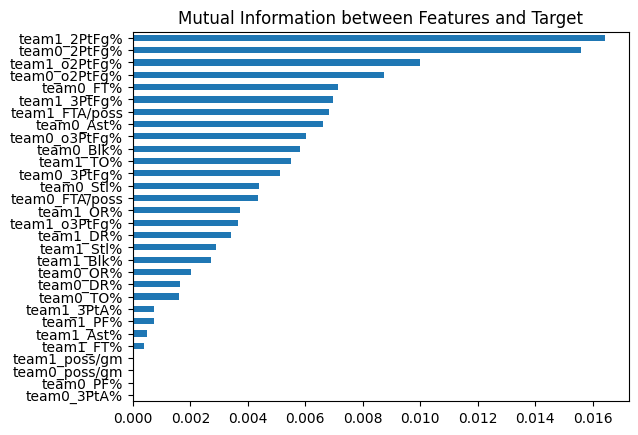

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression


mi = mutual_info_regression(X_train_df, y_train_df)
mi_series = pd.Series(mi, index=X_train_df.columns)

# Plot
plt.figure(10, 8)
mi_series.sort_values().plot(kind="barh", title="Mutual Information between Features and Target")
plt.show()

## Adding more features

- team avg height, PF/C avg height, experience, and tempo (removing possessions), and offensive and defensive adjusted efficiency extracted using `add_kenpom_stats.ipynb`

- as of now the off. & def. adj. efficiency stats are from the entire season (straight off Kenpom), as I haven't looked into how to hand calculate this game by game. This technically is considered a data leak because a team's end-of-reg-season efficiency contains information about that game's performance, but that's negligible when considering there is no data leakage from the test set (tournament games) and this feature adds significant predictive ability to the model on the test set.

In [ ]:
filepath = "../data_2025/kp/"
files = os.listdir(filepath)
data = pd.read_csv("../data_2025/clean/data.csv")

new_df = pd.DataFrame()

for f in files:
    yr = int(f[-8:-4])
    year_teams = pd.read_csv(filepath+f)
    year_teams = year_teams.set_index('Team')  # Set 'Team' as index for faster lookup
    # get all games from that year in data
    games = data[data["year"].astype(int) == yr]
    
    team0_cols = year_teams.columns.to_list()
    team1_cols = year_teams.columns.to_list()
    
    def process_game(game):
        id0 = str(game["team0_ID"])
        id1 = str(game["team1_ID"])

        if id0 in year_teams.index and id1 in year_teams.index:
            team0_data = year_teams.loc[id0].to_dict()
            team1_data = year_teams.loc[id1].to_dict()
            team0_data = {"team0_" + k: v for k, v in team0_data.items()}
            team1_data = {"team1_" + k: v for k, v in team1_data.items()}
            
            return pd.Series({**game.to_dict(), **team0_data, **team1_data})
        else:
            return None

    processed_games = games.apply(process_game, axis=1)
    processed_games = processed_games.dropna()

    new_df = pd.concat([new_df, processed_games], ignore_index=True)
    
new_df.to_csv("../data_2025/clean/new_data.csv", index=False)
new_df.head()

,team0_2PtFg%,team0_3PtA%,team0_3PtFg%,team0_FTA/poss,team0_FT%,team0_OR%,team0_DR%,team0_Ast%,team0_TO%,team0_Stl%,...,team0_Experience,team0_Tempo-Adj,team0_Off. Efficiency-Adj,team0_Def. Efficiency-Adj,team1_AvgHgt,team1_EffHgt,team1_Experience,team1_Tempo-Adj,team1_Off. Efficiency-Adj,team1_Def. Efficiency-Adj
0,0.519637,0.423345,0.349794,0.283078,0.643979,0.419558,0.755682,0.529183,0.211938,0.098574,...,1.83,65.3,113.1,87.7,75.8,-4.2,0.79,62.6,95.3,107.9
1,0.459893,0.320000,0.352273,0.253072,0.596859,0.287975,0.747396,0.589744,0.271622,0.102896,...,1.42,64.4,90.8,99.4,77.2,2.4,1.89,68.7,108.2,103.6
2,0.512195,0.309764,0.385870,0.288564,0.703349,0.402556,0.762712,0.587189,0.216768,0.104482,...,1.60,68.6,114.5,101.4,77.0,1.5,1.86,69.9,99.9,108.1
3,0.526820,0.332481,0.338462,0.271691,0.701613,0.341289,0.750000,0.611570,0.170903,0.137438,...,1.89,69.3,113.3,100.2,76.1,-1.4,1.48,62.9,92.4,106.8
4,0.485106,0.324713,0.323009,0.335921,0.716981,0.415190,0.726744,0.428571,0.166059,0.144771,...,1.92,69.2,110.5,104.5,78.7,3.5,1.55,62.7,107.6,101.9


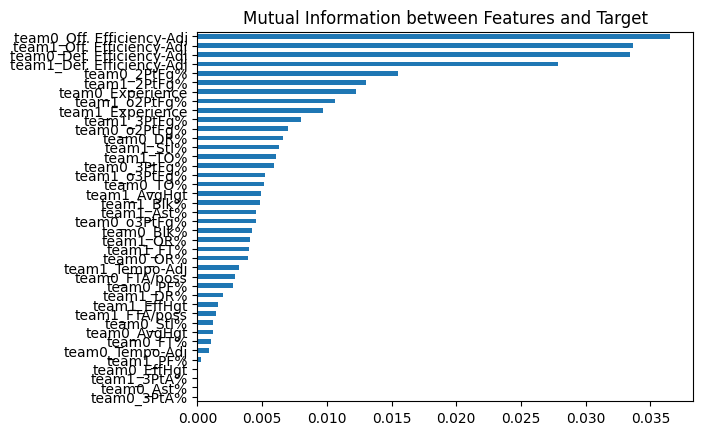

In [ ]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

df = pd.read_csv("../data_2025/clean/new_data.csv")
X_train_df = df[df["day"] < 134]
y_train_df = X_train_df["winner"]
X_train_df = X_train_df.drop(columns=cols_to_drop)
mi = mutual_info_regression(X_train_df, y_train_df)
mi_series = pd.Series(mi, index=X_train_df.columns)

# Plot
plt.figure(10, 8)
mi_series.sort_values().plot(kind="barh", title="Mutual Information between Features and Target")
plt.show()

## Add Momentum information

- weighted average of performance over past games